In [1]:
spark

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 6, Finished, Available)

In [2]:
blob_account_name = "marckvnonprodblob"
blob_container_name = "bigdata"
# read only
blob_sas_token = "?sv=2021-10-04&st=2023-10-04T01%3A42%3A59Z&se=2024-01-02T02%3A42%3A00Z&sr=c&sp=rlf&sig=w3CH9MbCOpwO7DtHlrahc7AlRPxSZZb8MOgS6TaXLzI%3D"

wasbs_base_url = (
    f"wasbs://{blob_container_name}@{blob_account_name}.blob.core.windows.net/"
)
spark.conf.set(
    f"fs.azure.sas.{blob_container_name}.{blob_account_name}.blob.core.windows.net",
    blob_sas_token,
)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 7, Finished, Available)

In [3]:
submissions_path = "reddit-parquet/submissions/"
submissions_df = spark.read.parquet(f"{wasbs_base_url}{submissions_path}")

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 8, Finished, Available)

In [4]:
from pyspark.sql.functions import col, asc,desc

submissions_filtered = submissions_df.filter(col("subreddit").isin(["Minecraft", "Eldenring","Genshin_Impact","pokemongo","RocketLeagueExchange","VALORANT","DestinyTheGame","CallOfDutyMobile","FIFA","pokemon"]))

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 9, Finished, Available)

In [5]:
df_text = submissions_filtered.select("subreddit", "title", "selftext","over_18","spoiler","is_video").cache()

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 10, Finished, Available)

In [6]:
from pyspark.sql.functions import concat_ws
df = df_text.withColumn("text", concat_ws(" ", df_text.title, df_text.selftext))

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 11, Finished, Available)

In [7]:
df.show(5)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 12, Finished, Available)

+---------+--------------------+--------------------+-------+-------+--------+--------------------+
|subreddit|               title|            selftext|over_18|spoiler|is_video|                text|
+---------+--------------------+--------------------+-------+-------+--------+--------------------+
|     FIFA|if you every get ...|                    |  false|  false|   false|if you every get ...|
|Minecraft|     Texting a house|So I’m building a...|  false|  false|   false|Texting a house S...|
| VALORANT|       Killjoy Mains|Got bored and so ...|  false|  false|   false|Killjoy Mains Got...|
|Minecraft|Trident skeleton ...|                    |  false|  false|   false|Trident skeleton ...|
|  pokemon|the PokemonTogeth...|So several days a...|  false|  false|   false|the PokemonTogeth...|
+---------+--------------------+--------------------+-------+-------+--------+--------------------+
only showing top 5 rows



In [8]:
from pyspark.sql.functions import lower
df = df.withColumn("text_lower", lower(df.text))

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 13, Finished, Available)

In [9]:
df = df.drop(*["title","selftext","text"])
df.show(5)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 14, Finished, Available)

+---------+-------+-------+--------+--------------------+
|subreddit|over_18|spoiler|is_video|          text_lower|
+---------+-------+-------+--------+--------------------+
|     FIFA|  false|  false|   false|if you every get ...|
|Minecraft|  false|  false|   false|texting a house s...|
| VALORANT|  false|  false|   false|killjoy mains got...|
|Minecraft|  false|  false|   false|trident skeleton ...|
|  pokemon|  false|  false|   false|the pokemontogeth...|
+---------+-------+-------+--------+--------------------+
only showing top 5 rows



# assign keywords labels

In [10]:
keyword_lst = [
    ["bug","error","issue","glitch","crash","freeze","lag","problems","problem","corruption","restart"],
    ["strategies","strategy","tip","trick","tactic","review","playthrough","speedrun","trophy","trophies","speedrun","achievements","quests","mission","stuck","help"],
    ["story","storyline","plot","narrative","characters","dialogue","twist","protagonist","antagonist","villian","backstory","emotion","choice","suspense","sexy","waifu"],
    ["lore","world","mythology","culture","retcon","documents","race","racial","cultural","environment","environmental","artifacts","cosmology","asian","american","african","background"],
    ["trade","buy","sell","transaction","market","scam","valuation","negotiation","currency","credit","auction","rarity","tax","fee","traders","buyers","sellers","money","dollar"]
]

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 15, Finished, Available)

In [11]:
from pyspark.sql.functions import when
df_label = df.withColumn("label",
                   when(col("text_lower").rlike("|".join(keyword_lst[0])), "bug report")
                   .when(col("text_lower").rlike("|".join(keyword_lst[1])), "gameplay discussion")
                   .when(col("text_lower").rlike("|".join(keyword_lst[2])), "story related discussion")
                   .when(col("text_lower").rlike("|".join(keyword_lst[3])), "lore discussion")
                   .when(col("text_lower").rlike("|".join(keyword_lst[4])), "game items trading")
                   .otherwise("other"))
df_label.show(5)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 16, Finished, Available)

+---------+-------+-------+--------+--------------------+-------------------+
|subreddit|over_18|spoiler|is_video|          text_lower|              label|
+---------+-------+-------+--------+--------------------+-------------------+
|     FIFA|  false|  false|   false|if you every get ...|              other|
|Minecraft|  false|  false|   false|texting a house s...|              other|
| VALORANT|  false|  false|   false|killjoy mains got...| game items trading|
|Minecraft|  false|  false|   false|trident skeleton ...|         bug report|
|  pokemon|  false|  false|   false|the pokemontogeth...|gameplay discussion|
+---------+-------+-------+--------+--------------------+-------------------+
only showing top 5 rows



# check the distribution of each labels

In [ ]:
df_label_cnt = df_label.groupBy("label").count().orderBy(col("count"), ascending=False).collect()

In [21]:
df_label_cnt_tot = spark.createDataFrame(df_label_cnt).toPandas()
df_label_cnt_tot

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 56, 26, Finished, Available)

,label,count
0,other,3925294
1,bug report,358867
2,game items trading,330996
3,gameplay discussion,240189
4,lore discussion,150275
5,story related discussion,86385


In [22]:
df_label_cnt_game = df_label.groupBy("subreddit","label").count().orderBy(col("count"), ascending=False).collect()

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 56, 27, Finished, Available)

In [23]:
df_label_cnt_sub = spark.createDataFrame(df_label_cnt_game).toPandas()
df_label_cnt_sub

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 56, 28, Finished, Available)

,subreddit,label,count
0,Minecraft,other,671646
1,Eldenring,other,634060
2,Genshin_Impact,other,555686
3,pokemongo,other,373640
4,VALORANT,other,317794
5,CallOfDutyMobile,other,312899
6,FIFA,other,297790
7,pokemon,other,291050
8,DestinyTheGame,other,253196
9,RocketLeagueExchange,other,217533


In [24]:
import os
CSV_DIR = os.path.join("Users/ky285/fall-2023-reddit-project-team-11/data", "csv")
df_label_cnt_tot.to_csv(f"{CSV_DIR}/total_label_count.csv", index=False)
df_label_cnt_sub.to_csv(f"{CSV_DIR}/game_label_count.csv", index=False)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 56, 29, Finished, Available)

# train test validation split

In [13]:
df_ml = df_label.filter((col("label") == "bug report") | (col("label") == "gameplay discussion") | (col("label") == "story related discussion") | (col("label") == "lore discussion") | (col("label") == "game items trading"))

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 18, Finished, Available)

In [14]:
df_ml = df_ml.withColumn("over_18_str", col("over_18").cast("string"))
df_ml = df_ml.withColumn("spoiler_str", col("spoiler").cast("string"))
df_ml = df_ml.withColumn("is_video_str", col("is_video").cast("string"))

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 19, Finished, Available)

In [15]:
df_ml.show(5)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 20, Finished, Available)

+--------------------+-------+-------+--------+--------------------+-------------------+-----------+-----------+------------+
|           subreddit|over_18|spoiler|is_video|          text_lower|              label|over_18_str|spoiler_str|is_video_str|
+--------------------+-------+-------+--------+--------------------+-------------------+-----------+-----------+------------+
|            VALORANT|  false|  false|   false|killjoy mains got...| game items trading|      false|      false|       false|
|           Minecraft|  false|  false|   false|trident skeleton ...|         bug report|      false|      false|       false|
|             pokemon|  false|  false|   false|the pokemontogeth...|gameplay discussion|      false|      false|       false|
|RocketLeagueExchange|   true|  false|   false|[xbox] [h] og tac...|gameplay discussion|       true|      false|       false|
|           Eldenring|  false|  false|   false|opinion: i do not...|    lore discussion|      false|      false|      

In [16]:
df_ml = df_ml.drop(*["subreddit","over_18","spoiler","is_video"])

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 21, Finished, Available)

In [17]:
df_ml2 = df_ml.sample(withReplacement=False, fraction=0.2, seed=42) # create the sample df

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 22, Finished, Available)

In [18]:
df_ml.printSchema

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 23, Finished, Available)

<bound method DataFrame.printSchema of DataFrame[text_lower: string, label: string, over_18_str: string, spoiler_str: string, is_video_str: string]>

In [19]:
train_data, test_data, val_data = df_ml2.randomSplit([0.8, 0.18, 0.02], 24)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 24, Finished, Available)

In [40]:
train_data2, test_data2, val_data2 = df_ml.randomSplit([0.8, 0.18, 0.02], 24)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 45, Finished, Available)

In [27]:
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
print("Number of validation records : " + str(val_data.count()))
train_data.cache()

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 56, 32, Finished, Available)

Number of training records: 932198
Number of testing records : 210806
Number of validation records : 23708


DataFrame[subreddit: string, title: string, selftext: string, text: string, text_lower: string, label: string]

# ML pipeline

In [20]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 25, Finished, Available)

In [30]:
stringIndexer_label = StringIndexer(inputCol="label", outputCol="label_success")
#stringIndexer_subreddit = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")
#stringIndexer_author = StringIndexer(inputCol="author", outputCol="author_ix")
stringIndexer_adult = StringIndexer(inputCol="over_18_str", outputCol="over_18_ix")
stringIndexer_spoiler = StringIndexer(inputCol="spoiler_str", outputCol="spoiler_ix")
stringIndexer_video = StringIndexer(inputCol="is_video_str", outputCol="is_video_ix")

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 35, Finished, Available)

In [57]:
'''
onehot_subreddit = OneHotEncoder(inputCol="subreddit_ix", outputCol="subreddit_vec")
onehot_author = OneHotEncoder(inputCol="author_ix", outputCol="author_vec")
'''

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 57, 62, Finished, Available)

In [31]:
'''
vectorAssembler_features = VectorAssembler(
    inputCols=["subreddit_vec", "author_vec"], 
    outputCol= "str_feature")
'''
vectorAssembler_features = VectorAssembler(
    inputCols=["over_18_ix", "spoiler_ix", "is_video_ix"], 
    outputCol= "str_feature")

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 36, Finished, Available)

# Hyperparameter set-up

In [32]:
# random forest classifier hyperparameters
num_tree1 = 30
max_depth1 = 2
num_tree2 = 50
max_depth2 = 3

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 37, Finished, Available)

In [33]:
model_rf1 = RandomForestClassifier(labelCol="label_success", featuresCol="str_feature", numTrees=num_tree1, maxDepth=max_depth1)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 38, Finished, Available)

In [34]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels= ["bug report", "gameplay discussion", "story related discussion","lore discussion","game items trading"])

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 39, Finished, Available)

In [35]:
'''
pipeline_model_rf = Pipeline(stages=[stringIndexer_label, 
                               stringIndexer_subreddit, 
                               stringIndexer_author, 
                               stringIndexer_adult,
                               stringIndexer_spoiler,
                               stringIndexer_video, 
                               onehot_author,
                               onehot_subreddit,
                               vectorAssembler_features, 
                               model_rf1, labelConverter])

'''

pipeline_model_rf = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_adult,
                               stringIndexer_spoiler,
                               stringIndexer_video,
                               vectorAssembler_features, 
                               model_rf1, labelConverter])

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 40, Finished, Available)

In [36]:
model_rf1 = pipeline_model_rf.fit(train_data)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 41, Finished, Available)

In [41]:
model_rf_full = pipeline_model_rf.fit(train_data2)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 46, Finished, Available)

In [37]:
pred_rf1 = model_rf1.transform(test_data)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 42, Finished, Available)

In [42]:
pred_rf_full = model_rf_full.transform(test_data2)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 47, Finished, Available)

In [43]:
pred_rf_full.show(5)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 48, Finished, Available)

+--------------------+-------------------+-----------+-----------+------------+-------------+----------+----------+-----------+-----------+--------------------+--------------------+----------+--------------+
|          text_lower|              label|over_18_str|spoiler_str|is_video_str|label_success|over_18_ix|spoiler_ix|is_video_ix|str_feature|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+-------------------+-----------+-----------+------------+-------------+----------+----------+-----------+-----------+--------------------+--------------------+----------+--------------+
|[pc] [h] 10 credi...| game items trading|      false|      false|       false|          2.0|       0.0|       0.0|        0.0|  (3,[],[])|[10.4616877092860...|[0.34872292364286...|       0.0|    bug report|
|[psn] [h] credits...| game items trading|      false|      false|       false|          2.0|       0.0|       0.0|        0.0|  (3,[],[])|[10.4616877092860...|[0.34872

In [44]:
eval_rf_full = MulticlassClassificationEvaluator(labelCol="label_success", predictionCol="prediction", metricName="accuracy")
accu_rf_full = eval_rf_full.evaluate(pred_rf_full)
print("Accuracy = %g" % accu_rf_full)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 49, Finished, Available)

Accuracy = 0.354529


# confusion matrix

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 50, Finished, Available)

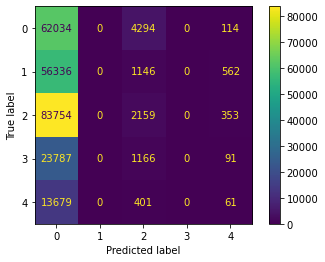

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred_rf=pred_rf_full.select("predictedLabel").collect()
y_orig_rf=pred_rf_full.select("label").collect()

cm = confusion_matrix(y_orig_rf, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig("cm_rf1.png")
plt.show()

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 54, Finished, Available)

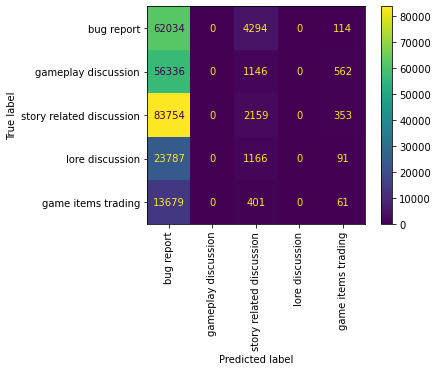

In [49]:
cm = confusion_matrix(y_orig_rf, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bug report", "gameplay discussion", "story related discussion","lore discussion","game items trading"])
disp.plot()
plt.xticks(rotation=90)
plt.savefig("./cm_rf1.png")
plt.show()

# rerun the random forest classifier with different parameters for comparison

In [50]:
model_rf2 = RandomForestClassifier(labelCol="label_success", featuresCol="str_feature", numTrees=num_tree2, maxDepth=max_depth2)
pipeline_model_rf = Pipeline(stages=[stringIndexer_label,
                               stringIndexer_adult,
                               stringIndexer_spoiler,
                               stringIndexer_video,
                               vectorAssembler_features, 
                               model_rf2, labelConverter])

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 55, Finished, Available)

In [51]:
model_rf_full2 = pipeline_model_rf.fit(train_data2)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 56, Finished, Available)

In [52]:
pred_rf_full2 = model_rf_full2.transform(test_data2)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 57, Finished, Available)

In [53]:
eval_rf_full2 = MulticlassClassificationEvaluator(labelCol="label_success", predictionCol="prediction", metricName="accuracy")
accu_rf_full2 = eval_rf_full2.evaluate(pred_rf_full2)
print("Accuracy = %g" % accu_rf_full2)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 58, Finished, Available)

Accuracy = 0.354525


We found out that there is no difference between different parameters

In [55]:
model_rf_full.save('Users/ky285/fall-2023-reddit-project-team-11/code/ML/rf_game_labels.h5')

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 58, 60, Submitted, Running)